In [469]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xbbg import blp
from pandas.tseries.offsets import *
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False


# import backtestModuleVer2


revL = ['NZD', 'EUR', 'AUD', 'GBP']

personalPool = ['EUR', 'JPY', 'GBP', 'CHF', 'AUD', 'CAD', 'NZD', 'SEK', 'INR', 'IDR', 'ZAR', 'CNH', 'KRW']
# personalPool = ['EUR', 'JPY', 'GBP', 'CHF', 'AUD', 'CAD', 'NZD', 'SEK', 'ZAR', 'CNH'] # delete NDF
# personalPool = ['EUR', 'JPY', 'GBP', 'CHF', 'AUD', 'CAD', 'NZD', 'SEK', 'ZAR'] # delete NDF and CNH
# personalPool = ['CHF', 'SEK', 'ZAR'] # 損益主要由這三個貨幣貢獻，但僅作這三個貨幣SR僅0.67

# personalPool = ['EUR', 'JPY', 'GBP', 'CHF', 'CAD', 'SEK', 'ZAR']

basket = personalPool

# personalPool = ['EUR', 'JPY', 'GBP', 'CHF', 'AUD', 'CAD', 'NZD', 'SEK', 'ZAR', 'CNH']


#########################################

startDate = '2012-01-01'
endDate = '2024-09-30'
# endDate = '2023-12-31'


# startDate = '2024-01-01'
endDate = '2025-03-24'


dr = pd.date_range(
    start=pd.to_datetime(startDate),
    end=pd.to_datetime(endDate),
    freq=BDay()
)   


#########################################
# get the weekend return gap
close = pd.read_csv(r'@@spot_BGNT_close.csv')
open = pd.read_csv(r'@@spot_BGNT_open.csv')

#close = close.fillna(method='ffill')
#open = open.fillna(method='ffill')
tmpL = [open, close]

for i in tmpL:
    i.rename(columns={'Unnamed: 0':'Date'}, inplace=True)
    i.index = i['Date']
    i.drop(columns='Date', inplace=True)
    i.index = pd.DatetimeIndex(i.index)

# open = open.reindex(dr).ffill()
# close = close.reindex(dr).ffill()

open = open.reindex(dr)
close = close.reindex(dr)

open = open[basket]
close = close[basket]
friClose = close.resample('W-Fri').ffill()
monOpen = open.resample('W-Mon').ffill()
monOpen = monOpen.iloc[1:, ] # for 2012 start
# monOpen = monOpen.iloc[1:, ]

# this is the weekend gap return
monIndex = monOpen.index
weekGap = (monOpen.reset_index(drop=True)-friClose.reset_index(drop=True))/friClose.reset_index(drop=True)
weekGap = weekGap.iloc[:-1, :]
weekGap.index = monIndex

weekGap = weekGap.fillna(method='ffill')



quantile = 0.50 # 0.50
def getUpQuantile(s, quantile, dir): # s 代表的是一段時間的 week Gap 的平均
    if dir == 'up':
        hThres = s.quantile(1-quantile)
        return hThres
    elif dir == 'down':
        lThres = s.quantile(quantile)
        return lThres
    
rollPeriod = 10 # original parameter: 10
rollWeekGapUp = weekGap.rolling(rollPeriod).apply(getUpQuantile , kwargs={'quantile':quantile, 'dir':'up'})
rollWeekGapDown = weekGap.rolling(rollPeriod).apply(getUpQuantile , kwargs={'quantile':quantile, 'dir':'down'})

goShort = weekGap[weekGap > rollWeekGapUp]
goLong = weekGap[weekGap < rollWeekGapDown]

goLong.replace(np.nan, 0, inplace=True)
goShort.replace(np.nan, 0, inplace=True)

w = 1/len(basket)

def replaceVal(row):
    for x in row:
        if x != 0:
            row.replace(x, w, inplace=True)
    return row

long = goLong.apply(replaceVal, axis=1)
short = goShort.apply(replaceVal, axis=1)

signalDf = long + short*-1
newSignal = signalDf.resample('1B').ffill()
newSignal.loc[newSignal.index.dayofweek == 4, ] = 0 # 每周五均關倉



In [470]:
spot = pd.read_csv(r'@@spot.csv')
tmpL = [spot]
for i in tmpL:
    i.rename(columns={'Unnamed: 0':'Date'}, inplace=True)
    i.index = i['Date']
    i.drop(columns='Date', inplace=True)
    i.index = pd.DatetimeIndex(i.index)


spot = spot.reindex(dr).ffill()


#delL = ['ZAR']
delL = []
test = [i for i in basket if i not in delL]
basket = personalPool
# btSpot = spot[basket].dropna()
btSpot = spot[basket]

# generate daily return
btDailyRet = btSpot.apply(lambda col: (col-col.shift(1))/col, axis=0)

btDailyRet = btDailyRet[basket]

In [471]:
newSignal2 = signalDf.copy()

In [472]:
# delete the signal when on weekday the daily return exceeds 1%
# Iterate through each day in newSignal
import datetime
from pandas.tseries.offsets import BDay
exceed_1_percent = {}

for signal_date in newSignal2.index[:-2]:
    # Get the next week's range (Monday to Friday)
    next_week = pd.date_range(start=signal_date, 
                              end=signal_date + BDay(4), 
                              freq='B')
    
    # Check if daily returns exceed 1% during the next week
    if not next_week.empty:
        daily_ret_next_week = btDailyRet.loc[next_week, :]
        exceed = daily_ret_next_week[daily_ret_next_week < -0.01]
        
        # Store results if any exceed 1%
        if not exceed.empty:
            exceed_1_percent[signal_date] = exceed

# # Display the results
# for signal_date, exceed_data in exceed_1_percent.items():
#     print(f"Signal Date: {signal_date}")
#     print("Days exceeding 1%:")
#     print(exceed_data)
#     print("-" * 50)

In [473]:
possibleRevL = ['EUR', 'GBP', 'AUD', 'JPY', 'NZD'] # original setup
# possibleRevL = ['AUD', 'NZD']
# possibleRevL = ['EUR', 'GBP', 'JPY']

for i in newSignal.columns:
    if i in possibleRevL:
        newSignal.loc[:, i] = -1 * newSignal.loc[:, i]

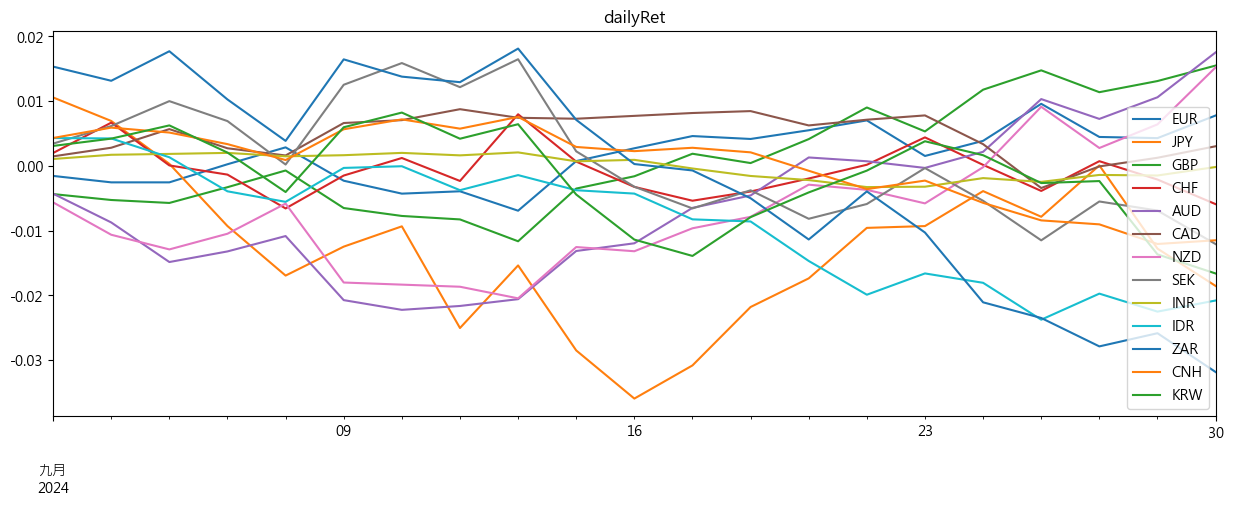

In [474]:
btDailyRet[basket].loc['2024-09-01':'2024-09-30', :].cumsum().plot(figsize=(15, 5), title='dailyRet')
plt.show()

In [475]:
btDailyRet[basket].loc['2024-08-01':'2024-08-30', :]

,EUR,JPY,GBP,CHF,AUD,CAD,NZD,SEK,INR,IDR,ZAR,CNH,KRW
2024-08-01,-0.001574,-0.007006,-0.003752,-0.004904,0.003066,-0.001085,0.004035,-0.004157,0.000203,-0.001170,0.001239,0.003311,-0.006376
2024-08-02,0.000278,-0.004423,-0.006214,-0.005735,-0.001843,0.003460,0.000168,0.002841,-0.000639,-0.001974,-0.001202,-0.004504,0.002628
2024-08-05,0.013243,-0.039863,0.006409,-0.022759,-0.009769,0.000432,-0.003881,-0.016523,0.001789,-0.000988,0.013777,-0.010870,-0.000950
2024-08-06,-0.002013,0.012457,-0.004317,0.004089,0.007693,-0.003108,-0.001352,-0.003563,0.001162,-0.001794,0.004948,0.000798,0.005581
2024-08-07,-0.000458,0.009476,-0.003229,-0.000117,0.007483,-0.005085,0.015308,-0.005638,-0.000328,-0.008045,-0.011503,0.006204,-0.001113
2024-08-08,0.001645,-0.005621,0.000157,0.003609,-0.000153,-0.001965,-0.002669,-0.000373,0.000566,-0.008745,0.003127,-0.003700,0.000458
2024-08-09,-0.001648,0.009103,0.004858,0.008084,0.006977,-0.000291,0.004484,0.005032,-0.000149,0.002009,-0.006333,0.001631,-0.007000
2024-08-12,0.000000,0.000068,0.000470,0.002419,0.001061,-0.000947,0.000830,-0.000761,0.000238,0.001817,-0.003372,0.000947,0.002891
2024-08-13,0.000732,0.004328,0.003123,-0.001153,0.001059,0.000510,0.002813,0.000751,-0.000030,-0.008151,-0.002203,-0.001073,0.000620
2024-08-14,0.006905,-0.003053,0.002337,-0.003937,0.003920,-0.001313,-0.004989,-0.006231,-0.000095,-0.009568,-0.006298,-0.003652,-0.009949


In [476]:
# Ensure btDailyRet and newSignal are reindexed to match the business day range
btDailyRet = btDailyRet.reindex(dr).fillna(0)  # Fill missing returns with 0
newSignal = newSignal.reindex(dr).fillna(0)    # Fill missing signals with 0

# Iterate through each day in btDailyRet
for date in btDailyRet.index[:-1]:  # Exclude the last day since there's no "next day"
    # Iterate through each currency
    for currency in newSignal.columns:
        signal = newSignal.loc[date, currency]
        spot_return = btDailyRet.loc[date, currency]

        # Check the signal and spot return conditions
        thres = -1 * 0.01 * 1
        if signal > 0 and spot_return < thres:
            # Close the signal for the remaining weekdays
            next_day = date + pd.Timedelta(days=1)
            friday = next_day + pd.Timedelta(days=(4 - next_day.weekday()))  # Find the upcoming Friday
            date_range = pd.date_range(start=next_day, end=friday, freq='B')

            for signal_date in date_range:
                if signal_date in newSignal.index:
                    newSignal.loc[signal_date, currency] = 0
            print(f"Signal closed for {currency} from {next_day.date()} to {friday.date()} due to signal > 0 and spot return < -1% on {date.date()}")

        elif signal < 0 and spot_return > -1 * thres:
            # Close the signal for the remaining weekdays
            next_day = date + pd.Timedelta(days=1)
            friday = next_day + pd.Timedelta(days=(4 - next_day.weekday()))  # Find the upcoming Friday
            date_range = pd.date_range(start=next_day, end=friday, freq='B')

            for signal_date in date_range:
                if signal_date in newSignal.index:
                    newSignal.loc[signal_date, currency] = 0
            print(f"Signal closed for {currency} from {next_day.date()} to {friday.date()} due to signal < 0 and spot return > 1% on {date.date()}")
    # # Check for two consecutive daily negative returns of 0.5% or more
    # if date > btDailyRet.index[0]:  # Ensure there is a previous day
    #     prev_date = date - pd.Timedelta(days=1)
    #     if prev_date in btDailyRet.index:
    #         consecutive_negative = (btDailyRet.loc[prev_date] < -0.005) & (btDailyRet.loc[date] < -0.005)
    #         if consecutive_negative.any():
    #             # Determine the range of dates for the remaining weekdays
    #             next_day = date + pd.Timedelta(days=1)
    #             friday = next_day + pd.Timedelta(days=(4 - next_day.weekday()))  # Find the upcoming Friday
    #             date_range = pd.date_range(start=next_day, end=friday, freq='B')
                
    #             # Set the signal to 0 for all currencies in the date range
    #             for signal_date in date_range:
    #                 if signal_date in newSignal.index:
    #                     newSignal.loc[signal_date] = 0
                        
    #                     # Print out the currencies and date
    #                     for currency in consecutive_negative[consecutive_negative].index:
    #                         print(f"Signal set to 0 for {currency} from {signal_date.date()} due to two consecutive negative returns on {prev_date.date()} and {date.date()}")

Signal closed for JPY from 2012-03-15 to 2012-03-16 due to signal < 0 and spot return > 1% on 2012-03-14
Signal closed for CHF from 2012-03-15 to 2012-03-16 due to signal < 0 and spot return > 1% on 2012-03-14
Signal closed for ZAR from 2012-03-16 to 2012-03-16 due to signal < 0 and spot return > 1% on 2012-03-15
Signal closed for AUD from 2012-04-05 to 2012-04-06 due to signal > 0 and spot return < -1% on 2012-04-04
Signal closed for INR from 2012-04-05 to 2012-04-06 due to signal < 0 and spot return > 1% on 2012-04-04
Signal closed for EUR from 2012-04-17 to 2012-04-20 due to signal > 0 and spot return < -1% on 2012-04-16
Signal closed for NZD from 2012-04-17 to 2012-04-20 due to signal > 0 and spot return < -1% on 2012-04-16
Signal closed for CHF from 2012-04-18 to 2012-04-20 due to signal > 0 and spot return < -1% on 2012-04-17
Signal closed for CAD from 2012-04-19 to 2012-04-20 due to signal > 0 and spot return < -1% on 2012-04-18
Signal closed for ZAR from 2012-04-19 to 2012-04-2

In [477]:
# # Ensure btDailyRet and newSignal are reindexed to match the business day range
# btDailyRet = btDailyRet.reindex(dr).fillna(0)  # Fill missing returns with 0
# newSignal = newSignal.reindex(dr).fillna(0)    # Fill missing signals with 0

# # Iterate through each day in btDailyRet
# for date in btDailyRet.index[1:]:  # Start from the second day to check the previous day
#     prev_date = date - pd.Timedelta(days=1)
    
#     # Ensure both the current and previous dates exist in the index
#     if prev_date not in btDailyRet.index or date not in btDailyRet.index:
#         continue

#     # Iterate through each currency
#     for currency in newSignal.columns:
#         signal = newSignal.loc[date, currency]
#         prev_return = btDailyRet.loc[prev_date, currency]
#         curr_return = btDailyRet.loc[date, currency]

#         thres = -1 * 0.01 * 0.2 # % threshold for negative return
#         # Check the signal and consecutive returns
#         if signal > 0 and prev_return < thres and curr_return < thres:
#             # Signal > 0 and two consecutive negative returns
#             next_day = date + pd.Timedelta(days=1)
#             friday = next_day + pd.Timedelta(days=(4 - next_day.weekday()))  # Find the upcoming Friday
#             date_range = pd.date_range(start=next_day, end=friday, freq='B')

#             # Set the signal to 0 for the remaining weekdays
#             for signal_date in date_range:
#                 if signal_date in newSignal.index:
#                     newSignal.loc[signal_date, currency] = 0
#                     print(f"Signal set to 0 for {currency} from {signal_date.date()} due to two consecutive negative returns on {prev_date.date()} and {date.date()}")

#         elif signal < 0 and prev_return > -1*thres and curr_return > -1*thres:
#             # Signal < 0 and two consecutive positive returns
#             next_day = date + pd.Timedelta(days=1)
#             friday = next_day + pd.Timedelta(days=(4 - next_day.weekday()))  # Find the upcoming Friday
#             date_range = pd.date_range(start=next_day, end=friday, freq='B')

#             # Set the signal to 0 for the remaining weekdays
#             for signal_date in date_range:
#                 if signal_date in newSignal.index:
#                     newSignal.loc[signal_date, currency] = 0
#                     print(f"Signal set to 0 for {currency} from {signal_date.date()} due to two consecutive positive returns on {prev_date.date()} and {date.date()}")

In [478]:
newSignal.loc['2024-08-01':'2024-08-31', :]

,EUR,JPY,GBP,CHF,AUD,CAD,NZD,SEK,INR,IDR,ZAR,CNH,KRW
2024-08-01,0.076923,0.000000,-0.076923,-0.076923,0.076923,0.076923,0.076923,0.076923,0.076923,0.076923,-0.076923,0.076923,-0.076923
2024-08-02,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024-08-05,-0.076923,0.076923,0.076923,-0.076923,0.076923,0.076923,0.076923,0.076923,-0.076923,0.076923,0.076923,0.076923,0.076923
2024-08-06,0.000000,0.000000,0.076923,-0.076923,0.076923,0.076923,0.076923,0.000000,-0.076923,0.076923,0.076923,0.000000,0.076923
2024-08-07,0.000000,0.000000,0.076923,-0.076923,0.076923,0.076923,0.076923,0.000000,-0.076923,0.076923,0.076923,0.000000,0.076923
2024-08-08,0.000000,0.000000,0.076923,-0.076923,0.076923,0.076923,0.076923,0.000000,-0.076923,0.076923,0.000000,0.000000,0.076923
2024-08-09,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024-08-12,-0.076923,0.076923,0.076923,0.000000,0.076923,0.076923,0.076923,0.076923,0.076923,-0.076923,0.076923,0.076923,0.076923
2024-08-13,-0.076923,0.076923,0.076923,0.000000,0.076923,0.076923,0.076923,0.076923,0.076923,-0.076923,0.076923,0.076923,0.076923
2024-08-14,-0.076923,0.076923,0.076923,0.000000,0.076923,0.076923,0.076923,0.076923,0.076923,-0.076923,0.076923,0.076923,0.076923


,return(%),dailyStd(%),yearlyMDD(%),yearlySharpe
2012,3.39,0.09,0.87,2.180
2013,0.53,0.13,1.82,0.250
2014,1.68,0.11,1.38,0.929
2015,2.35,0.17,2.53,0.850
2016,0.68,0.18,2.33,0.233
2017,0.72,0.11,2.17,0.400
2018,1.56,0.11,1.73,0.833
2019,-0.07,0.09,1.39,-0.048
2020,5.51,0.17,1.67,1.936
2021,1.35,0.10,1.37,0.796


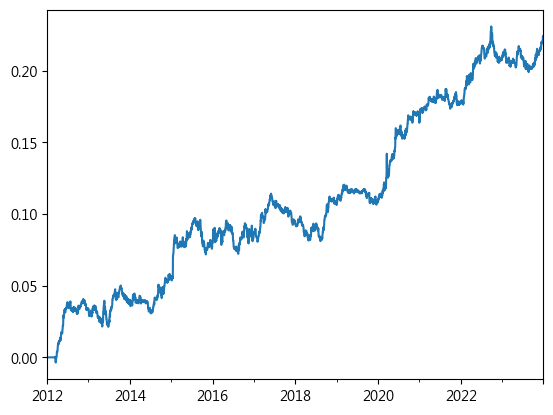

In [479]:
spot = pd.read_csv(r'@@spot.csv')
tmpL = [spot]
for i in tmpL:
    i.rename(columns={'Unnamed: 0':'Date'}, inplace=True)
    i.index = i['Date']
    i.drop(columns='Date', inplace=True)
    i.index = pd.DatetimeIndex(i.index)

spot = spot.reindex(dr).ffill()
spot = spot[basket]

# filtered_signals = apply_trend_filter(signalDf, spot, lookback=5)
# filtered_signals = filtered_signals.resample('1B').ffill()
# filtered_signals.loc[filtered_signals.index.dayofweek == 4, ] = 0 # 每周五均關倉





# for i in newSignal.columns:
#     if i in possibleRevL:
#          filtered_signals.loc[:, i] = -1 *  filtered_signals.loc[:, i]


def getStats(totalCount, dailyS):
    s = pd.Series()

    if totalCount >= 252:
        s['Mean'] = (dailyS[0:].sum()) / totalCount * 252
        s['Std'] = (dailyS[0:].std()) * np.sqrt(252)
    else:
        s['Mean'] = (dailyS[0:].sum()) / totalCount * totalCount
        s['Std'] = (dailyS[0:].std()) * np.sqrt(totalCount)

    s['Sharpe'] = s['Mean'] / s['Std']
    # mddForPlot = maxDDVer3(cumS)[0]
    # periodHigh = maxDDVer3(cumS)[1]
    # s['MDD'] = np.min(mddForPlot)
                                                                                                 
    return s


def calculate_detailed_mdd(daily_returns):
    cumulative_returns = daily_returns.cumsum()
    running_max = cumulative_returns.cummax()
    drawdown = running_max - cumulative_returns
    mdd_end_idx = drawdown.idxmax()
    mdd_value = drawdown[mdd_end_idx]
    mdd_start_idx = running_max.loc[:mdd_end_idx].idxmax()
    mdd_duration = (mdd_end_idx - mdd_start_idx).days
    return {
        "mdd_value": mdd_value,
        "mdd_start_date": mdd_start_idx,
        "mdd_end_date": mdd_end_idx,
        "mdd_duration": mdd_duration
    }



test = newSignal.reindex(dr).ffill()
# test_filter = filtered_signals.reindex(dr).ffill()

portDailyChange = btDailyRet * test.shift(1)
portDailyChange = portDailyChange[portDailyChange.index < '2024-01-01']
# portDailyChange = portDailyChange[portDailyChange.index > '2024-01-01']
portDailyChange['port'] = portDailyChange.sum(axis=1)
portDailyChange['port'].cumsum().plot()

getStats(totalCount=portDailyChange['port'].dropna().shape[0], dailyS=portDailyChange['port'])

# yearlyRes = pd.DataFrame(index=portDailyChange.index.year.unique())
yearlyRes = pd.DataFrame()

yearlyRes['return(%)'] = round(portDailyChange['port'].resample('YE').sum().reset_index(drop=True) * 100, 2)
yearlyRes['dailyStd(%)'] = round(portDailyChange['port'].resample('YE').std().reset_index(drop=True)* 100, 2)
yearlyRes['yearlyMDD(%)'] = round(portDailyChange['port'].resample('YE').apply(lambda x: calculate_detailed_mdd(x)['mdd_value']).reset_index(drop=True)* 100, 2)
yearlyRes['yearlySharpe'] = round(portDailyChange['port'].resample('YE').apply(lambda x: getStats(x.shape[0], x)['Sharpe']).reset_index(drop=True), 3)
yearlyRes.index = portDailyChange.index.year.unique()
yearlyRes.loc['回測期間', 'return(%)'] = round(getStats(totalCount=portDailyChange['port'].dropna().shape[0], dailyS=portDailyChange['port'])['Mean']*100, 2)
yearlyRes.loc['回測期間', 'dailyStd(%)'] = round(portDailyChange['port'].std()* 100, 2)
yearlyRes.loc['回測期間', 'yearlyMDD(%)'] = round(calculate_detailed_mdd(portDailyChange['port'])['mdd_value'] * 100, 2)
yearlyRes.loc['回測期間', 'yearlySharpe'] = round(getStats(totalCount=portDailyChange['port'].dropna().shape[0], dailyS=portDailyChange['port'])['Sharpe'], 3)
yearlyRes

Mean     -0.015342
Std       0.017346
Sharpe   -0.884491
dtype: float64

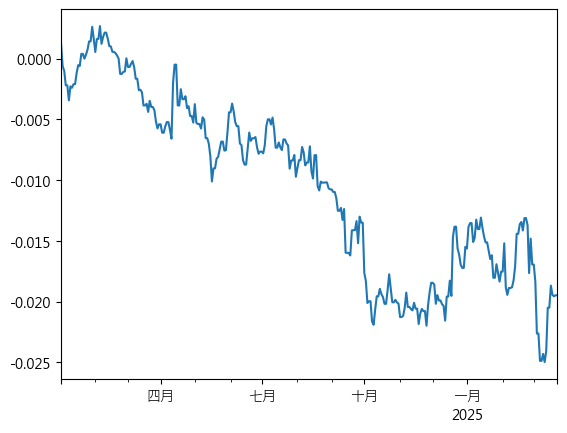

In [480]:
import matplotlib
matplotlib.rc('font', family='Microsoft JhengHei')

portDailyChange = btDailyRet * test.shift(1)

portDailyChange = portDailyChange[portDailyChange.index > '2024-01-01']
portDailyChange['port'] = portDailyChange.sum(axis=1)
portDailyChange['port'].cumsum().plot()

getStats(totalCount=portDailyChange['port'].dropna().shape[0], dailyS=portDailyChange['port'])

In [486]:

yearlyRes = pd.DataFrame()

yearlyRes['return(%)'] = round(portDailyChange['port'].resample('YE').sum().reset_index(drop=True) * 100, 2)
yearlyRes['dailyStd(%)'] = round(portDailyChange['port'].resample('YE').std().reset_index(drop=True)* 100, 2)
yearlyRes['yearlyMDD(%)'] = round(portDailyChange['port'].resample('YE').apply(lambda x: calculate_detailed_mdd(x)['mdd_value']).reset_index(drop=True)* 100, 2)
yearlyRes['yearlySharpe'] = round(portDailyChange['port'].resample('YE').apply(lambda x: getStats(x.shape[0], x)['Sharpe']).reset_index(drop=True), 3)
yearlyRes.index = portDailyChange.index.year.unique()
yearlyRes.loc['回測期間', 'return(%)'] = round(getStats(totalCount=portDailyChange['port'].dropna().shape[0], dailyS=portDailyChange['port'])['Mean']*100, 2)
yearlyRes.loc['回測期間', 'dailyStd(%)'] = round(portDailyChange['port'].std()* 100, 2)
yearlyRes.loc['回測期間', 'yearlyMDD(%)'] = round(calculate_detailed_mdd(portDailyChange['port'])['mdd_value'] * 100, 2)
yearlyRes.loc['回測期間', 'yearlySharpe'] = round(getStats(totalCount=portDailyChange['port'].dropna().shape[0], dailyS=portDailyChange['port'])['Sharpe'], 3)
yearlyRes

,return(%),dailyStd(%),yearlyMDD(%),yearlySharpe
2024,-1.55,0.10,2.47,-0.942
2025,-0.40,0.14,1.19,-0.360
回測期間,-1.53,0.11,2.77,-0.884


In [482]:
newSignal.loc['2024-09-01':'2024-09-30', :]

,EUR,JPY,GBP,CHF,AUD,CAD,NZD,SEK,INR,IDR,ZAR,CNH,KRW
2024-09-02,0.076923,-0.000000,0.076923,0.076923,0.076923,0.076923,0.076923,0.076923,-0.076923,-0.076923,0.076923,0.076923,0.076923
2024-09-03,0.076923,-0.000000,0.076923,0.076923,0.076923,0.076923,0.076923,0.076923,-0.076923,-0.076923,0.076923,0.076923,0.076923
2024-09-04,0.076923,-0.000000,0.076923,0.076923,0.076923,0.076923,0.076923,0.076923,-0.076923,-0.076923,0.076923,0.076923,0.076923
2024-09-05,0.076923,-0.000000,0.076923,0.076923,0.076923,0.076923,0.076923,0.076923,-0.076923,-0.076923,0.076923,0.076923,0.076923
2024-09-06,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024-09-09,-0.076923,0.076923,-0.076923,-0.076923,-0.076923,0.076923,-0.076923,-0.076923,-0.076923,-0.076923,0.076923,0.076923,0.076923
2024-09-10,-0.076923,0.076923,-0.076923,-0.076923,-0.076923,0.076923,-0.076923,0.000000,-0.076923,-0.076923,0.076923,0.076923,0.076923
2024-09-11,-0.076923,0.076923,-0.076923,-0.076923,-0.076923,0.076923,-0.076923,0.000000,-0.076923,-0.076923,0.076923,0.076923,0.076923
2024-09-12,-0.076923,0.000000,-0.076923,-0.076923,-0.076923,0.076923,-0.076923,0.000000,-0.076923,-0.076923,0.076923,0.076923,0.076923
2024-09-13,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


<Axes: title={'center': 'dailyRet'}>

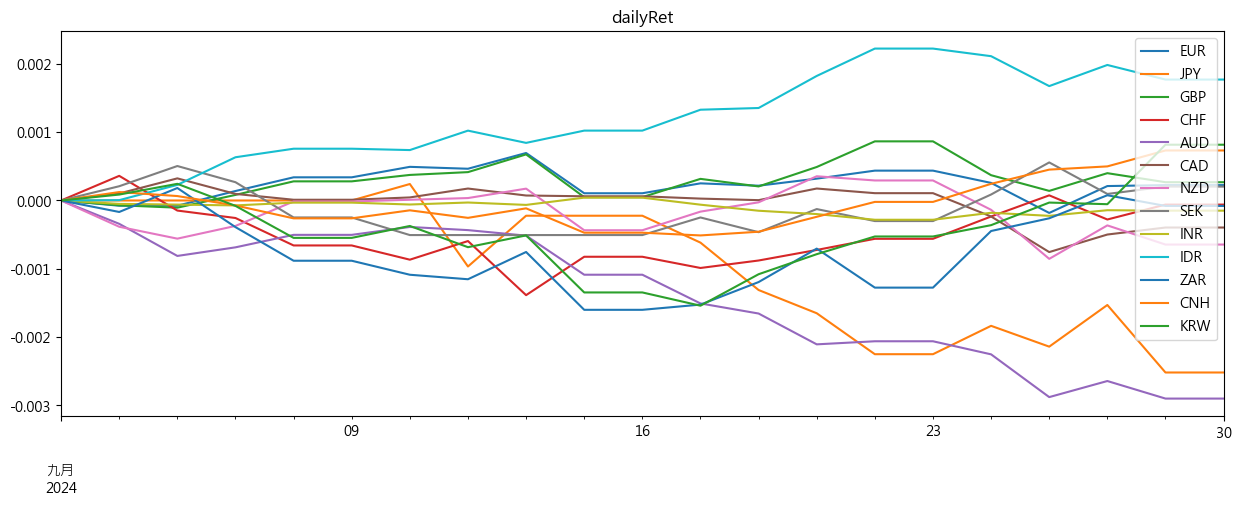

In [483]:
portDailyChange.loc['2024-09-01':'2024-09-30', ~portDailyChange.columns.isin(['port'])].cumsum().plot(figsize=(15, 5), title='dailyRet')

<Axes: title={'center': 'spot'}>

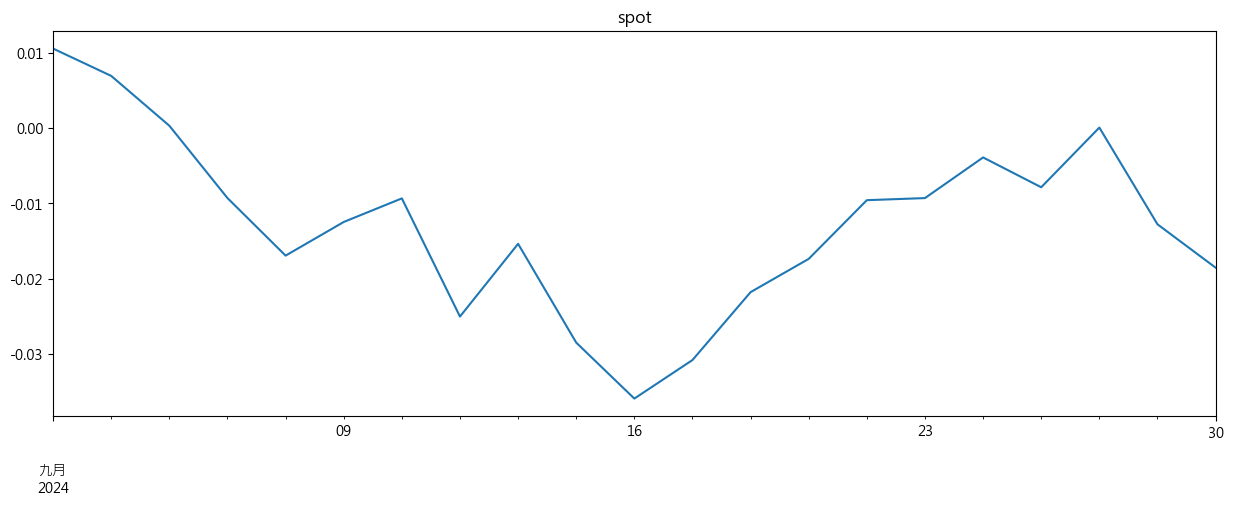

In [484]:
btDailyRet.loc['2024-09-01':'2024-09-30', :].cumsum()['JPY'].plot(figsize=(15, 5), title='spot')

Mean     -0.003848
Std       0.011082
Sharpe   -0.347275
dtype: float64

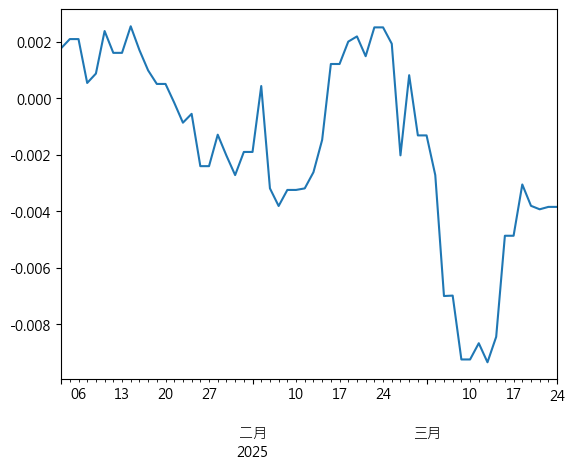

In [487]:
import matplotlib
matplotlib.rc('font', family='Microsoft JhengHei')

portDailyChange = btDailyRet * test.shift(1)

portDailyChange = portDailyChange[portDailyChange.index > '2025-01-01']
portDailyChange['port'] = portDailyChange.sum(axis=1)
portDailyChange['port'].cumsum().plot()

getStats(totalCount=portDailyChange['port'].dropna().shape[0], dailyS=portDailyChange['port'])

In [488]:

yearlyRes = pd.DataFrame()

yearlyRes['return(%)'] = round(portDailyChange['port'].resample('YE').sum().reset_index(drop=True) * 100, 2)
yearlyRes['dailyStd(%)'] = round(portDailyChange['port'].resample('YE').std().reset_index(drop=True)* 100, 2)
yearlyRes['yearlyMDD(%)'] = round(portDailyChange['port'].resample('YE').apply(lambda x: calculate_detailed_mdd(x)['mdd_value']).reset_index(drop=True)* 100, 2)
yearlyRes['yearlySharpe'] = round(portDailyChange['port'].resample('YE').apply(lambda x: getStats(x.shape[0], x)['Sharpe']).reset_index(drop=True), 3)
yearlyRes.index = portDailyChange.index.year.unique()
yearlyRes.loc['回測期間', 'return(%)'] = round(getStats(totalCount=portDailyChange['port'].dropna().shape[0], dailyS=portDailyChange['port'])['Mean']*100, 2)
yearlyRes.loc['回測期間', 'dailyStd(%)'] = round(portDailyChange['port'].std()* 100, 2)
yearlyRes.loc['回測期間', 'yearlyMDD(%)'] = round(calculate_detailed_mdd(portDailyChange['port'])['mdd_value'] * 100, 2)
yearlyRes.loc['回測期間', 'yearlySharpe'] = round(getStats(totalCount=portDailyChange['port'].dropna().shape[0], dailyS=portDailyChange['port'])['Sharpe'], 3)
yearlyRes

,return(%),dailyStd(%),yearlyMDD(%),yearlySharpe
2025,-0.38,0.15,1.19,-0.347
回測期間,-0.38,0.15,1.19,-0.347
